In [5]:
import requests
from bs4 import BeautifulSoup
from collections import defaultdict
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
sns.set_style('whitegrid')
%matplotlib inline
pd.options.display.max_rows = 1000

# 1. Beijing

In [3]:
file_name = './wikipedia_html/beijing.txt'
response = requests.get("https://en.wikipedia.org/wiki/List_of_Beijing_Subway_stations")
response_text = response.text
with open(file_name, "w", encoding="utf-8") as file:
    file.write(response_text)

# Read the string back into a new variable
with open(file_name, "r", encoding="utf-8") as file:
    response_text_read = file.read()
print(response_text[:100])
print(response_text_read[:100])

<!DOCTYPE html>
<html class="client-nojs vector-feature-language-in-header-enabled vector-feature-la
<!DOCTYPE html>
<html class="client-nojs vector-feature-language-in-header-enabled vector-feature-la


# 2. Get remaining HTML

In [ ]:
city_to_url = [
    ('beijing', 'https://en.wikipedia.org/wiki/List_of_Beijing_Subway_stations'),
    ('Chengdu', 'https://en.wikipedia.org/wiki/List_of_Chengdu_Metro_stations'),
    ('Chongqing', 'https://en.wikipedia.org/wiki/List_of_Chongqing_Rail_Transit_stations'),
    ('Dalian', 'https://en.wikipedia.org/wiki/List_of_Dalian_Metro_stations'),
    ('Guangzhou', 'https://en.wikipedia.org/wiki/List_of_Guangzhou_Metro_stations'),
    ('Hangzhou', 'https://en.wikipedia.org/wiki/List_of_Hangzhou_Metro_stations'),
    ('Nanjing', 'https://en.wikipedia.org/wiki/List_of_Nanjing_Metro_stations'),
    ('Shanghai', 'https://en.wikipedia.org/wiki/List_of_Shanghai_Metro_stations'),
    ('Shenyang', 'https://en.wikipedia.org/wiki/List_of_Shenyang_Metro_stations'),
    ('Shenzhen', 'https://en.wikipedia.org/wiki/List_of_Shenzhen_Metro_stations'),
    ('Shijiazhuang', 'https://en.wikipedia.org/wiki/List_of_Shijiazhuang_Metro_stations'),
    ('Suzhou', 'https://en.wikipedia.org/wiki/List_of_Suzhou_Rail_Transit_stations'),
    ('Wuhan', 'https://en.wikipedia.org/wiki/List_of_Wuhan_Metro_stations'),
    ('Xian', 'https://en.wikipedia.org/wiki/List_of_Xi%27an_Metro_stations'),
]

In [ ]:
for city_name, url in city_to_url:
    response = requests.get(url)
    with open(f'./wikipedia_html/{city_name}.txt', "w", encoding="utf-8") as file:
        file.write(response.text)
    print(city_name, len(response.text))
    time.sleep(5)

Chengdu 360948
Chongqing 288748
Dalian 85686
Guangzhou 298967
Hangzhou 334341
Nanjing 433019
Shanghai 1044116
Shenyang 152971
Shenzhen 366223
Shijiazhuang 136856
Suzhou 187156
Wuhan 262539
Xian 202173


# 3. Parse tables from each HTML to get station names

In [156]:
# Define columns of interest for each metro
city_to_columns = [
    ('Beijing', False, 'Station', 'Chinese name'),
    ('Chengdu', 'Station name', 'English', 'Chinese'),
    ('Chongqing', 'Station name', 'English', 'Chinese'),
    ('Dalian', False, 'Station', 'Chinese name'),
    ('Guangzhou', False, 'Station', 'Chinese name'),
    ('Hangzhou', 'Station name', 'English', 'Chinese'),
    ('Nanjing', False, 'Station nameEnglish', 'Station nameMandarin'),
    # ('Nanjing', False, 'Station name English', 'Station name Chinese'),
    ('Shanghai', 'Station Name', 'English', 'Chinese (S)'),
    ('Shenyang', 'station name', 'Pinyin', 'Chinese'),
    ('Shenzhen', 'Station name', 'English', 'Chinese'),
    ('Shijiazhuang', 'Station name', 'English', 'Chinese'),
    ('Suzhou', 'Station name', 'English', 'Chinese'),
    ('Wuhan', False, 'Station name(English)', 'Station name(Chinese)'),
    ('Xian', False, 'Station nameEnglish', 'Station nameMandarin'),
]


#  'Station Name',
#  'Opened',
#  'Location',
#  'Platform Level',
#  'Type of Platform',
#  'Transfers',
#  'English',
#  'Chinese S']

In [194]:
def remove_parentheses_and_numbers(s):
    return re.sub(r'[0-9\[\]]+', '', s)

dict_stations = defaultdict(list)
for city_name, top_level_col_name, english_col_name, chinese_col_name in city_to_columns:
    english_col_name = english_col_name.lower()
    chinese_col_name = chinese_col_name.lower()

    # Load html for the city and identify all tables
    with open(f'./wikipedia_html/{city_name}.txt', "r", encoding="utf-8") as file:
        response_text = file.read()
    soup = BeautifulSoup(response_text, 'html.parser')
    tables = soup.find_all('table')
    # print(f'{city_name} # tables: {len(tables)}')

    # Loop through each table
    for table_idx, table in enumerate(tables):
        # Get table header / column names
        headers = table.find_all('th')
        header_texts = [header.get_text(strip=True) for header in headers]
        header_texts = [h.lower() for h in header_texts]

        if top_level_col_name is False:
            # Check if table has proper columns
            if english_col_name in header_texts and chinese_col_name in header_texts:
                chinese_col_index = header_texts.index(chinese_col_name)
                english_index = header_texts.index(english_col_name)
                
                # Find all rows in the table body
                rows = table.find_all('tr')
                for i_row, row in enumerate(rows[1:]):  # Skip header row
                    cells = row.find_all(['td', 'th'])  # Sometimes headers repeat in body
                    if len(cells) > chinese_col_index:
                        chinese_text = cells[chinese_col_index].get_text(strip=True)
                        english_text = cells[english_index].get_text(strip=True)
                        dict_stations['city_name'].append(city_name)
                        dict_stations['chinese'].append(chinese_text)
                        dict_stations['english'].append(english_text)
                        dict_stations['station_number'].append(i_row)

        else:
            top_level_col_name = top_level_col_name.lower()
            # Remove all brackets and numbers from header texts
            header_texts = [remove_parentheses_and_numbers(h) for h in header_texts]
            header_texts = [h.lower() for h in header_texts]

            # Check if table has proper columns
            if top_level_col_name in header_texts and english_col_name in header_texts and chinese_col_name in header_texts:
                top_level_index = header_texts.index(top_level_col_name)
                english_index = sum([int(h.get('colspan', default=1)) for h in headers[:top_level_index]])
                chinese_col_index = english_index + 1

                # Find all rows in the table body
                rows = table.find_all('tr')
                for i_row, row in enumerate(rows[2:]):  # Skip header rows
                    cells = row.find_all(['td', 'th'])  # Sometimes headers repeat in body
                    if len(cells) > chinese_col_index:
                        chinese_text = cells[chinese_col_index].get_text(strip=True)
                        english_text = cells[english_index].get_text(strip=True)
                        dict_stations['city_name'].append(city_name)
                        dict_stations['chinese'].append(chinese_text)
                        dict_stations['english'].append(english_text)
                        # dict_stations['line_number'].append(line_number)
                        dict_stations['station_number'].append(i_row)
    # print(len(dict_stations['station_number']))
                

df_stations = pd.DataFrame(dict_stations)

# Remove strange Wuhan artifact
df_stations = df_stations[~df_stations['chinese'].str.contains('Chinese')].reset_index(drop=True)

# Drop duplicates
print(f'# stations, pre de-dup: {len(df_stations)}')
df_stations = df_stations.drop_duplicates(subset=['city_name', 'chinese'])

print(f'# stations: {len(df_stations)}')
print(df_stations['city_name'].value_counts())
df_stations.sample(10)

# stations, pre de-dup: 3773
# stations: 3199
city_name
Beijing         416
Shanghai        408
Shenzhen        332
Guangzhou       293
Chengdu         291
Wuhan           263
Hangzhou        257
Nanjing         247
Chongqing       226
Suzhou          174
Xian            102
Shenyang         85
Shijiazhuang     62
Dalian           43
Name: count, dtype: int64


,city_name,chinese,english,station_number
368,Beijing,俸伯,Fengbo,19
1964,Nanjing,平良大街,Pingliangdajie,119
3592,Wuhan,纸坊大街,Zhifang Avenue,32
299,Beijing,五道口,Wudaokou,3
645,Chengdu,太升南路,Taisheng South Road,20
3436,Wuhan,黄龙山路,Huanglongshan Road,34
3455,Wuhan,菱角湖,Lingjiaohu,15
1632,Hangzhou,同协路,Tongxie Road,36
2957,Shenzhen,深湾,Shenwan,12
1741,Hangzhou,阳陂湖,Yangbeihu,31


# 4. Process data and get character counts

In [205]:
# Remove all parentheses and numbers using regex
def remove_parentheses_and_numbers(s):
    return re.sub(r'[0-9()·\[\]]+', '', s)

all_char = ''.join(df_stations['chinese'].values)
all_char = list(remove_parentheses_and_numbers(all_char))

# Get counts of all characters
char_counts = pd.Series(all_char).value_counts().reset_index().rename(columns={"index": 'char'})
print(char_counts.head(10))
print(len(char_counts), char_counts['count'].sum())

  char  count
0    路    646
1    大    242
2    园    183
3    桥    174
4    南    160
5    东    158
6    北    143
7    西    135
8    山    130
9    新    124
1164 10027


# 3. get pinyin

In [196]:
def load_pinyin_dict(filename):
    pinyin_dict = {}

    with open(filename, "r", encoding="utf-8") as file:
        for line in file:
            line = line.strip()

            # Skip empty lines or comments
            if not line or line.startswith("#"):
                continue

            # Split line at '#' to separate the Chinese character
            parts = line.split("#")
            if len(parts) < 2:
                continue

            chinese_char = parts[1].strip()  # e.g., 㐀

            # Split left side at ':' to get Pinyin
            left_part = parts[0].split(":")
            if len(left_part) < 2:
                continue

            pinyin = left_part[1].strip()  # e.g., qiū

            # Add to dictionary
            pinyin_dict[chinese_char] = pinyin

    return pinyin_dict

# Downloaded file from https://github.com/mozillazg/pinyin-data/blob/27dc54a206326e0d8d91428010325f50f614508d/pinyin.txt
char_to_pinyin_dict = load_pinyin_dict("pinyin.txt")
print(char_to_pinyin_dict['㐀'])  # Output: qiū

qiū


In [197]:
def get_example_stations(char, n_examples=3):
    return list(df_stations[df_stations['chinese'].str.contains(char)].head(n_examples)['chinese'].values)

char_counts['pinyin_all'] = char_counts['char'].map(char_to_pinyin_dict)
char_counts['pinyin'] = char_counts['pinyin_all'].apply(lambda x: str(x).split(',')[0])
char_counts['char_pinyin'] = char_counts.apply(lambda row: f"{row['pinyin']} {row['char']}", axis=1)
char_counts['examples'] = char_counts['char'].apply(get_example_stations)
char_counts.head(50)

,char,count,pinyin_all,pinyin,char_pinyin,examples
0,路,646,"lù,luò",lù,lù 路,"[玉泉路, 万寿路, 南礼士路]"
1,大,242,"dà,dài,tài",dà,dà 大,"[大望路, 传媒大学, 鼓楼大街]"
2,园,183,"yuán,wán",yuán,yuán 园,"[苹果园, 八角游乐园, 果园]"
3,桥,174,qiáo,qiáo,qiáo 桥,"[双桥, 八里桥, 土桥]"
4,南,160,"nán,nā",nán,nán 南,"[南礼士路, 北京南站, 高米店南]"
5,东,158,dōng,dōng,dōng 东,"[天安门东, 东单, 四惠东]"
6,北,143,"běi,bèi",běi,běi 北,"[通州北苑, 北京站, 安河桥北]"
7,西,135,xī,xī,xī 西,"[西单, 天安门西, 西直门]"
8,山,130,shān,shān,shān 山,"[八宝山, 九龙山, 昌平西山口]"
9,新,124,xīn,xīn,xīn 新,"[新街口, 新宫, 北新桥]"


# 4. plot character frequency

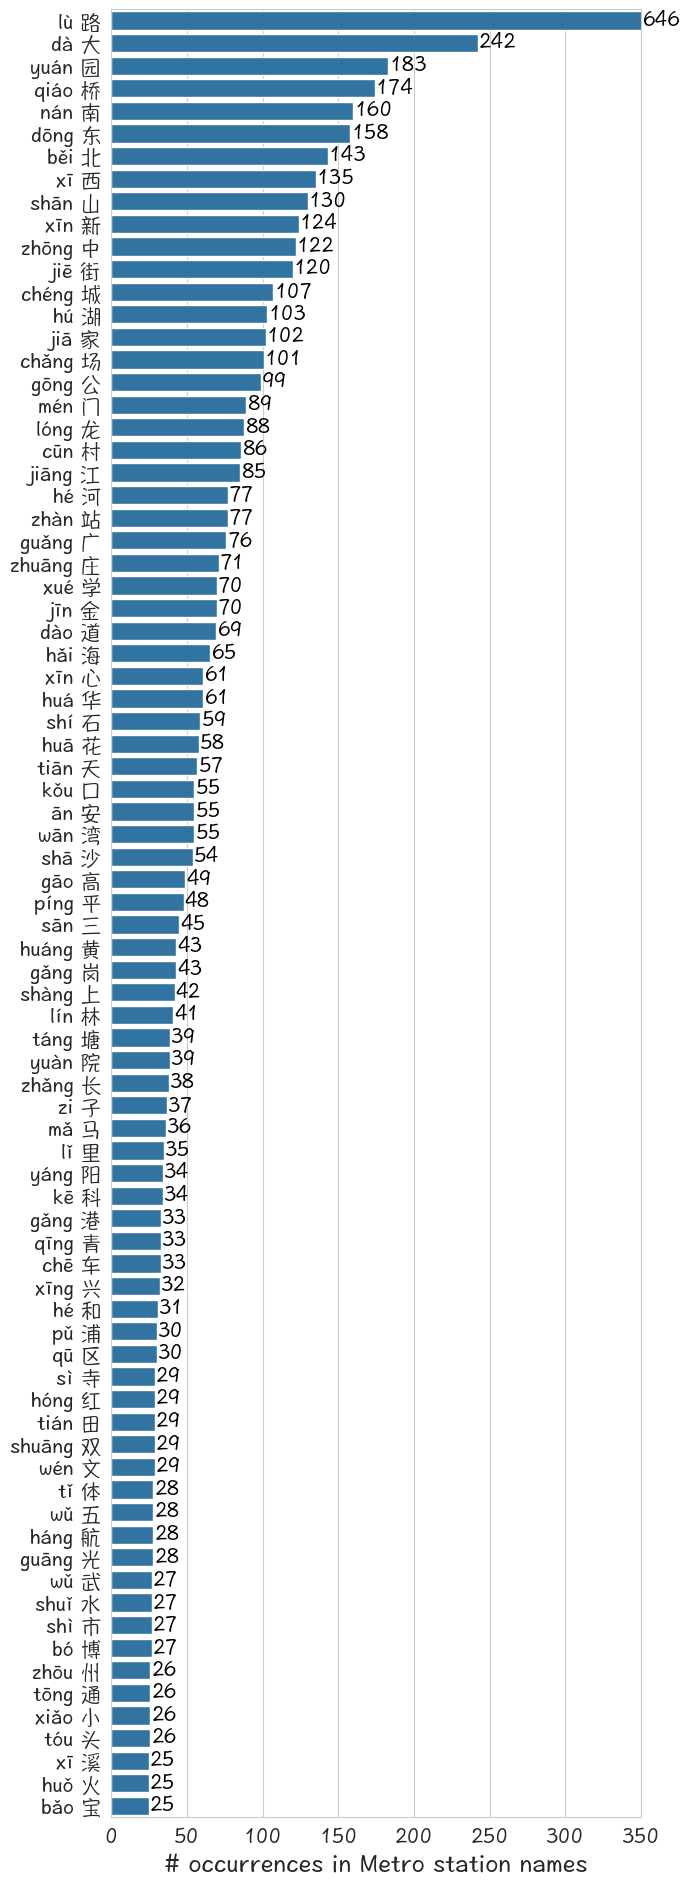

In [200]:
df_plt = char_counts[char_counts['count'] > 24].dropna().reset_index(drop=True)

# Plot bars
xaxis_limit = 350
plt.rcParams['font.family'] = 'Hannotate SC'
plt.figure(figsize=(7,19))
g = sns.barplot(x='count', y='char_pinyin', data=df_plt)

# Plot numbers
for index, row in df_plt.iterrows():
    g.text(x=min(row['count'], xaxis_limit) + .7,
           y=index + .2,
           s=row['count'],
           color='black',
           ha="left",
           size=15)

plt.ylabel('')
plt.xlabel('# occurrences in Metro station names', size=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim((0,xaxis_limit))
plt.tight_layout()
    
plt.savefig('./character_rankings_15metros.png')


# 5. top character combos

In [206]:
# Create string to use in getting character sequence counts
all_stations_str = '_'.join(df_stations['chinese'])
all_stations_str = remove_parentheses_and_numbers(all_stations_str)
print(all_stations_str[:100])

# Get all charater sequences, not including numbers or certain characters
all_seq2 = []
all_seq3 = []
all_seq4 = []
all_seq5 = []
all_seq6 = []
for let1, let2, let3, let4, let5, let6 in zip(all_stations_str[:-5], all_stations_str[1:-4], all_stations_str[2:-3], all_stations_str[3:-2], all_stations_str[4:-1], all_stations_str[5:]):
    all_seq2.append(f'{let1}{let2}')
    all_seq3.append(f'{let1}{let2}{let3}')
    all_seq4.append(f'{let1}{let2}{let3}{let4}')
    all_seq5.append(f'{let1}{let2}{let3}{let4}{let5}')
    all_seq6.append(f'{let1}{let2}{let3}{let4}{let5}{let6}')

# Remove certain characters of no interest
seq2_counts = pd.Series(all_seq2).value_counts().reset_index().rename(columns={"index": 'char'})
seq2_counts = seq2_counts[~seq2_counts['char'].str.contains('_')]
seq3_counts = pd.Series(all_seq3).value_counts().reset_index().rename(columns={"index": 'char'})
seq3_counts = seq3_counts[~seq3_counts['char'].str.contains('_')]
seq4_counts = pd.Series(all_seq4).value_counts().reset_index().rename(columns={"index": 'char'})
seq4_counts = seq4_counts[~seq4_counts['char'].str.contains('_')]
seq5_counts = pd.Series(all_seq5).value_counts().reset_index().rename(columns={"index": 'char'})
seq5_counts = seq5_counts[~seq5_counts['char'].str.contains('_')]
seq6_counts = pd.Series(all_seq6).value_counts().reset_index().rename(columns={"index": 'char'})
seq6_counts = seq6_counts[~seq6_counts['char'].str.contains('_')]

print(seq2_counts[:5])
print(seq3_counts[:5])
print(seq4_counts[:5])
print(seq5_counts[:5])
print(seq6_counts[:5])

号_福寿岭_苹果园_古城_八角游乐园_八宝山_玉泉路_五棵松_万寿路_公主坟_军事博物馆_木樨地_南礼士路_复兴门_西单_天安门西_天安门东_王府井_东单_建国门_永安里_国贸_大望路_四惠_四惠东_
   char  count
6    公园     75
17   大道     58
20   广场     56
22   中心     52
24   大学     48
   char  count
16  火车站     14
29  航站楼     11
32  体育中      9
36  育中心      9
40  山公园      9
    char  count
3   体育中心      9
7   号航站楼      7
9   会展中心      6
12  奥体中心      6
21  医药大学      4
     char  count
8   中医药大学      4
19  号号航站楼      3
21  良乡大学城      3
31  双流机场航      2
34  野生动物园      2
      char  count
9   流机场航站楼      2
10  双流机场航站      2
17  天府机场号号      2
29  府机场号号航      2
34  江北机场T航      2


In [223]:
# Create dataframe of multi-character combo frequencies
# Columns: Chinese, char count, pinyin, examples
df_char_combo_counts = pd.concat([seq2_counts, seq3_counts, seq4_counts, seq5_counts, seq6_counts])
df_char_combo_counts = df_char_combo_counts[df_char_combo_counts['count'] >= 3]
df_char_combo_counts['n_char'] = df_char_combo_counts['char'].apply(lambda x: len(x))

# Get pinyin
def get_pinyin_of_char_combo(chars):
    pinyin = ''
    for char in chars:
        pinyin += char_to_pinyin_dict[char].split(',')[0]
    return pinyin

df_char_combo_counts['pinyin'] = df_char_combo_counts['char'].apply(get_pinyin_of_char_combo)
df_char_combo_counts['char_pinyin'] = df_char_combo_counts.apply(lambda row: f"{row['pinyin']} {row['char']}", axis=1)

# Get examples
df_char_combo_counts['examples'] = df_char_combo_counts['char'].apply(get_example_stations)
df_char_combo_counts.sort_values('count', ascending=False).head(20)

,char,count,n_char,pinyin,char_pinyin,examples
6,公园,75,2,gōngyuán,gōngyuán 公园,"[森林公园南门, 奥林匹克公园, 朝阳公园]"
17,大道,58,2,dàdào,dàdào 大道,"[华府大道, 迎宾大道, 熊猫大道]"
20,广场,56,2,guǎngchǎng,guǎngchǎng 广场,"[天府广场, 锦城广场, 双流广场]"
22,中心,52,2,zhōngxīn,zhōngxīn 中心,"[奥体中心, 亦创会展中心, 奥体中心]"
24,大学,48,2,dàxué,dàxué 大学,"[传媒大学, 北京大学东门, 人民大学]"
49,南路,26,2,nánlù,nánlù 南路,"[丰台南路, 农大南路, 红莲南路]"
54,大街,23,2,dàjiē,dàjiē 大街,"[鼓楼大街, 黄村西大街, 回龙观东大街]"
57,西路,22,2,xīlù,xīlù 西路,"[马超西路, 清江西路, 凤西路]"
62,北路,21,2,běilù,běilù 北路,"[人民北路, 金科北路, 草堂北路]"
61,机场,21,2,jīchǎng,jīchǎng 机场,"[大兴机场, 双流机场1航站楼, 双流机场2航站楼]"


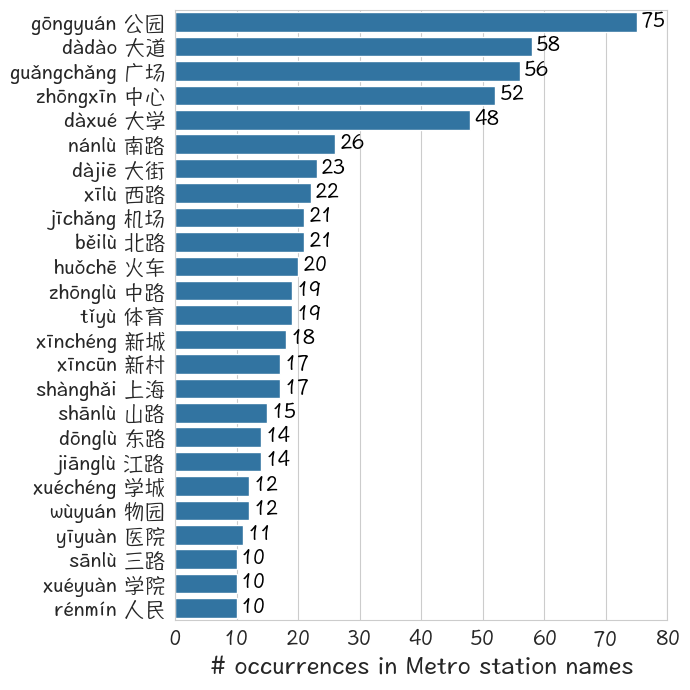

In [ ]:
df_plt = df_char_combo_counts[(df_char_combo_counts['count'] > 9) & (df_char_combo_counts['n_char']==2)].dropna().reset_index(drop=True)

# Remove those with zhan
df_plt = df_plt[~df_plt['char'].str.contains('站')].reset_index(drop=True)

# Plot bars
xaxis_limit = 80
plt.rcParams['font.family'] = 'Hannotate SC'
plt.figure(figsize=(7,7))
g = sns.barplot(x='count', y='char_pinyin', data=df_plt)

# Plot numbers
for index, row in df_plt.iterrows():
    g.text(x=min(row['count'], xaxis_limit) + .7,
           y=index + .2,
           s=row['count'],
           color='black',
           ha="left",
           size=15)

plt.ylabel('')
plt.xlabel('# occurrences in Metro station names', size=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim((0,xaxis_limit))
plt.tight_layout()
    
plt.savefig('./character_rankings_15metros_2char.png')


# 6. 3+ combo

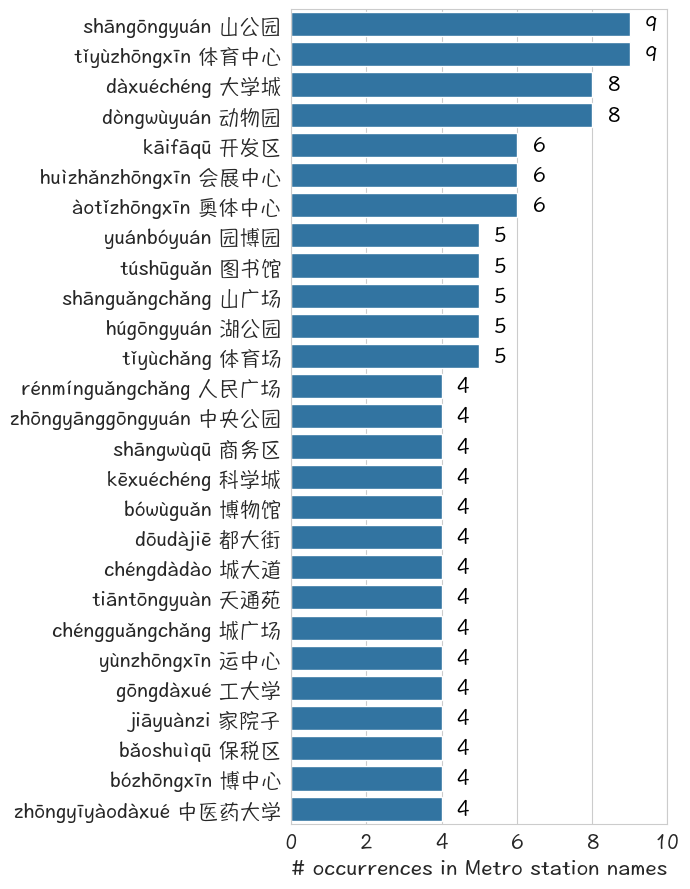

In [239]:
df_plt = df_char_combo_counts[(df_char_combo_counts['count'] > 3) & (df_char_combo_counts['n_char']>=3)].dropna().sort_values('count', ascending=False).reset_index(drop=True)

# Remove those with zhan
df_plt = df_plt[~df_plt['char'].str.contains('站')].reset_index(drop=True)

# Remove a combo if it is within another one that is present
long_combos = df_plt[df_plt['n_char'] > 3]['char'].values
def determine_if_in_long_combo(char):
    for combo in long_combos:
        if len(char) < len(combo):
            if char in combo:
                return True
    return False
df_plt['is_in_longer_combo'] = df_plt['char'].apply(determine_if_in_long_combo)
df_plt = df_plt[~df_plt['is_in_longer_combo']].reset_index(drop=True)

# Plot bars
xaxis_limit = 10
plt.rcParams['font.family'] = 'Hannotate SC'
plt.figure(figsize=(7,9))
g = sns.barplot(x='count', y='char_pinyin', data=df_plt)

# Plot numbers
for index, row in df_plt.iterrows():
    g.text(x=min(row['count'], xaxis_limit) + .4,
           y=index + .2,
           s=row['count'],
           color='black',
           ha="left",
           size=15)

plt.ylabel('')
plt.xlabel('# occurrences in Metro station names', size=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim((0,xaxis_limit))
plt.tight_layout()
    
plt.savefig('./character_rankings_15metros_3char.png')
